In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage
from scipy.spatial import cKDTree

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

# Preparing for BGS Y4-6 Prediction

- Checking Anand Raichoor's `fiberassign` files
- Checking the completeness of the BGS targets

In [4]:
loc = '/Users/song/galaxy/desi/fiberassign'

sgc_cat = Table.read(os.path.join(loc, 'bright-sgc/targ-after-pass5.fits'))

In [6]:
print(sgc_cat.colnames)

['RA', 'DEC', 'TARGETID', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SUBPRIORITY', 'OBSCONDITIONS', 'PRIORITY_INIT', 'NUMOBS_INIT', 'SCND_TARGET', 'NFIBER_AVAIL', 'NTILE_AVAIL', 'NUMOBS_DONE', 'ISRADEC_SAFE', 'NUMOBS_MORE', 'NUMOBS', 'Z', 'ZWARN', 'ZTILEID', 'Z_QN', 'IS_QSO_QN', 'DELTACHI2', 'TARGET_STATE', 'TIMESTAMP', 'VERSION', 'PRIORITY']


In [11]:
# BGS in SGC
sgc_bgs = sgc_cat[sgc_cat['BGS_TARGET'] > 0]

print(len(sgc_bgs))

6320104


In [33]:
# BGS in NGC
ngc_cat = Table.read(os.path.join(loc, 'bright-ngc/targ-after-pass5.fits'))

ngc_bgs = ngc_cat[ngc_cat['BGS_TARGET'] > 0]

print(len(ngc_bgs))

14187580


In [43]:
bgs_cat = vstack([ngc_bgs, sgc_bgs])

print(len(bgs_cat))

20507684


In [67]:
# MWS targets

ngc_mws = ngc_cat[ngc_cat['MWS_TARGET'] > 0]
sgc_mws = sgc_cat[sgc_cat['MWS_TARGET'] > 0]

mws_cat = vstack([ngc_mws, sgc_mws])

In [68]:
print(len(mws_cat))

26023866


In [44]:
bgs_cat[1]

RA,DEC,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SCND_TARGET,NFIBER_AVAIL,NTILE_AVAIL,NUMOBS_DONE,ISRADEC_SAFE,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,Z_QN,IS_QSO_QN,DELTACHI2,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
float64,float64,int64,int64,int64,int64,float64,int32,int64,int64,int64,int64[6],int64[6],int64[6],bool,int64,int64,float64,int64,int32,float64,int16,float64,bytes30,bytes25,bytes14,int64
129.94478196513236,4.337557713578675,39627889548722586,1152921504606846976,131074,0,0.8308635630938688,516,2100,2,0,0 .. 0,0 .. 0,0 .. 0,True,0,1,-1.0,0,1,-1.0,-1,-1.0,BGS_BRIGHT|MORE_ZGOOD,2022-05-16T08:10:02+00:00,2.5.0,2


- `BGS_TARGET` bitmasks:
    - `1`: `BGS_FAINT`
    - `2`: `BGS_BRIGHT`

In [54]:
bgs_bright = bgs_cat[(bgs_cat["BGS_TARGET"] & 2) != 0]
bgs_faint = bgs_cat[(bgs_cat["BGS_TARGET"] & 1) != 0]

print(len(bgs_bright), len(bgs_faint))

12656074 7806053


In [56]:
area = 14861.0 # deg^2

In [65]:
# After Pass 1
bgs_bright_pass1 = bgs_bright['NUMOBS_DONE'][:, 0:1].sum(axis=1)
print((bgs_bright_pass1 > 0).sum() / len(bgs_bright_pass1))

# After Pass 2
bgs_bright_pass2 = bgs_bright['NUMOBS_DONE'][:, 0:2].sum(axis=1)
print((bgs_bright_pass2 > 0).sum() / len(bgs_bright_pass2))

# After Pass 3
bgs_bright_pass3 = bgs_bright['NUMOBS_DONE'][:, 0:3].sum(axis=1)
print((bgs_bright_pass3 > 0).sum() / len(bgs_bright_pass3))

# After Pass 4
bgs_bright_pass4 = bgs_bright['NUMOBS_DONE'][:, 0:4].sum(axis=1)
print((bgs_bright_pass4 > 0).sum() / len(bgs_bright_pass4))

# After Pass 5
bgs_bright_pass5 = bgs_bright['NUMOBS_DONE'][:, 0:5].sum(axis=1)
print((bgs_bright_pass5 > 0).sum() / len(bgs_bright_pass5))

# After Pass 6
bgs_bright_pass6 = bgs_bright['NUMOBS_DONE'][:, 0:6].sum(axis=1)
print((bgs_bright_pass6 > 0).sum() / len(bgs_bright_pass6))

0.2861090255951411
0.5084110601755331
0.6710901026653289
0.7864212867276219
0.8612050624862023
0.9095186232318174


In [66]:
# After Pass 1
bgs_faint_pass1 = bgs_faint['NUMOBS_DONE'][:, 0:1].sum(axis=1)
print((bgs_faint_pass1 > 0).sum() / len(bgs_faint_pass1))

# After Pass 2
bgs_faint_pass2 = bgs_faint['NUMOBS_DONE'][:, 0:2].sum(axis=1)
print((bgs_faint_pass2 > 0).sum() / len(bgs_faint_pass2))

# After Pass 3
bgs_faint_pass3 = bgs_faint['NUMOBS_DONE'][:, 0:3].sum(axis=1)
print((bgs_faint_pass3 > 0).sum() / len(bgs_faint_pass3))

# After Pass 4
bgs_faint_pass4 = bgs_faint['NUMOBS_DONE'][:, 0:4].sum(axis=1)
print((bgs_faint_pass4 > 0).sum() / len(bgs_faint_pass4))

# After Pass 5
bgs_faint_pass5 = bgs_faint['NUMOBS_DONE'][:, 0:5].sum(axis=1)
print((bgs_faint_pass5 > 0).sum() / len(bgs_faint_pass5))

# After Pass 6
bgs_faint_pass6 = bgs_faint['NUMOBS_DONE'][:, 0:6].sum(axis=1)
print((bgs_faint_pass6 > 0).sum() / len(bgs_faint_pass6))

0.14809443389636223
0.30674196037357165
0.4621377794898395
0.6003922853201227
0.7123512996901251
0.7976510023695714


In [69]:
# After Pass 1
mws_cat_pass1 = mws_cat['NUMOBS_DONE'][:, 0:1].sum(axis=1)
print((mws_cat_pass1 > 0).sum() / len(mws_cat_pass1))

# After Pass 2
mws_cat_pass2 = mws_cat['NUMOBS_DONE'][:, 0:2].sum(axis=1)
print((mws_cat_pass2 > 0).sum() / len(mws_cat_pass2))

# After Pass 3
mws_cat_pass3 = mws_cat['NUMOBS_DONE'][:, 0:3].sum(axis=1)
print((mws_cat_pass3 > 0).sum() / len(mws_cat_pass3))

# After Pass 4
mws_cat_pass4 = mws_cat['NUMOBS_DONE'][:, 0:4].sum(axis=1)
print((mws_cat_pass4 > 0).sum() / len(mws_cat_pass4))

# After Pass 5
mws_cat_pass5 = mws_cat['NUMOBS_DONE'][:, 0:5].sum(axis=1)
print((mws_cat_pass5 > 0).sum() / len(mws_cat_pass5))

# After Pass 6
mws_cat_pass6 = mws_cat['NUMOBS_DONE'][:, 0:6].sum(axis=1)
print((mws_cat_pass6 > 0).sum() / len(mws_cat_pass6))

0.03960772008278862
0.09550702420616522
0.16890645686540193
0.25476453037377306
0.3467808357144169
0.4375859835736935


In [77]:
np.unique(bgs_faint['PRIORITY_INIT'])

2000
2100


In [79]:
bgs_faint_low = bgs_faint[bgs_faint['PRIORITY_INIT'] == 2000]
bgs_faint_high = bgs_faint[bgs_faint['PRIORITY_INIT'] == 2100]

In [78]:
np.unique(bgs_bright['PRIORITY_INIT'])

2100
2998


In [80]:
bgs_bright_low = bgs_bright[bgs_bright['PRIORITY_INIT'] == 2100]
bgs_bright_high = bgs_bright[bgs_bright['PRIORITY_INIT'] == 2998]

In [81]:
# After Pass 1
bgs_bright_low_pass1 = bgs_bright_low['NUMOBS_DONE'][:, 0:1].sum(axis=1)
print((bgs_bright_low_pass1 > 0).sum() / len(bgs_bright_low_pass1))

# After Pass 2
bgs_bright_low_pass2 = bgs_bright_low['NUMOBS_DONE'][:, 0:2].sum(axis=1)
print((bgs_bright_low_pass2 > 0).sum() / len(bgs_bright_low_pass2))

# After Pass 3abs
bgs_bright_low_pass3 = bgs_bright_low['NUMOBS_DONE'][:, 0:3].sum(axis=1)
print((bgs_bright_low_pass3 > 0).sum() / len(bgs_bright_low_pass3))

# After Pass 4
bgs_bright_low_pass4 = bgs_bright_low['NUMOBS_DONE'][:, 0:4].sum(axis=1)
print((bgs_bright_low_pass4 > 0).sum() / len(bgs_bright_low_pass4))

# After Pass 5
bgs_bright_low_pass5 = bgs_bright_low['NUMOBS_DONE'][:, 0:5].sum(axis=1)
print((bgs_bright_low_pass5 > 0).sum() / len(bgs_bright_low_pass5))

# After Pass 6
bgs_bright_low_pass6 = bgs_bright_low['NUMOBS_DONE'][:, 0:6].sum(axis=1)
print((bgs_bright_low_pass6 > 0).sum() / len(bgs_bright_low_pass6))

0.286108574557056
0.508410714583426
0.6710898708673846
0.7864210335934749
0.8612048979860161
0.9095185159930117


In [82]:
# After Pass 1
bgs_bright_high_pass1 = bgs_bright_high['NUMOBS_DONE'][:, 0:1].sum(axis=1)
print((bgs_bright_high_pass1 > 0).sum() / len(bgs_bright_high_pass1))

# After Pass 2
bgs_bright_high_pass2 = bgs_bright_high['NUMOBS_DONE'][:, 0:2].sum(axis=1)
print((bgs_bright_high_pass2 > 0).sum() / len(bgs_bright_high_pass2))

# After Pass 3abs
bgs_bright_high_pass3 = bgs_bright_high['NUMOBS_DONE'][:, 0:3].sum(axis=1)
print((bgs_bright_high_pass3 > 0).sum() / len(bgs_bright_high_pass3))

# After Pass 4
bgs_bright_high_pass4 = bgs_bright_high['NUMOBS_DONE'][:, 0:4].sum(axis=1)
print((bgs_bright_high_pass4 > 0).sum() / len(bgs_bright_high_pass4))

# After Pass 5
bgs_bright_high_pass5 = bgs_bright_high['NUMOBS_DONE'][:, 0:5].sum(axis=1)
print((bgs_bright_high_pass5 > 0).sum() / len(bgs_bright_high_pass5))

# After Pass 6
bgs_bright_high_pass6 = bgs_bright_high['NUMOBS_DONE'][:, 0:6].sum(axis=1)
print((bgs_bright_high_pass6 > 0).sum() / len(bgs_bright_high_pass6))

0.6666666666666666
0.8
0.8666666666666667
1.0
1.0
1.0


In [83]:
# After Pass 1
bgs_faint_low_pass1 = bgs_faint_low['NUMOBS_DONE'][:, 0:1].sum(axis=1)
print((bgs_faint_low_pass1 > 0).sum() / len(bgs_faint_low_pass1))

# After Pass 2
bgs_faint_low_pass2 = bgs_faint_low['NUMOBS_DONE'][:, 0:2].sum(axis=1)
print((bgs_faint_low_pass2 > 0).sum() / len(bgs_faint_low_pass2))

# After Pass 3abs
bgs_faint_low_pass3 = bgs_faint_low['NUMOBS_DONE'][:, 0:3].sum(axis=1)
print((bgs_faint_low_pass3 > 0).sum() / len(bgs_faint_low_pass3))

# After Pass 4
bgs_faint_low_pass4 = bgs_faint_low['NUMOBS_DONE'][:, 0:4].sum(axis=1)
print((bgs_faint_low_pass4 > 0).sum() / len(bgs_faint_low_pass4))

# After Pass 5
bgs_faint_low_pass5 = bgs_faint_low['NUMOBS_DONE'][:, 0:5].sum(axis=1)
print((bgs_faint_low_pass5 > 0).sum() / len(bgs_faint_low_pass5))

# After Pass 6
bgs_faint_low_pass6 = bgs_faint_low['NUMOBS_DONE'][:, 0:6].sum(axis=1)
print((bgs_faint_low_pass6 > 0).sum() / len(bgs_faint_low_pass6))

0.10947317548577462
0.2503495354553297
0.4037928380101132
0.5484957925235042
0.6707810778294677
0.7663376899225377


In [84]:
# After Pass 1
bgs_faint_high_pass1 = bgs_faint_high['NUMOBS_DONE'][:, 0:1].sum(axis=1)
print((bgs_faint_high_pass1 > 0).sum() / len(bgs_faint_high_pass1))

# After Pass 2
bgs_faint_high_pass2 = bgs_faint_high['NUMOBS_DONE'][:, 0:2].sum(axis=1)
print((bgs_faint_high_pass2 > 0).sum() / len(bgs_faint_high_pass2))

# After Pass 3abs
bgs_faint_high_pass3 = bgs_faint_high['NUMOBS_DONE'][:, 0:3].sum(axis=1)
print((bgs_faint_high_pass3 > 0).sum() / len(bgs_faint_high_pass3))

# After Pass 4
bgs_faint_high_pass4 = bgs_faint_high['NUMOBS_DONE'][:, 0:4].sum(axis=1)
print((bgs_faint_high_pass4 > 0).sum() / len(bgs_faint_high_pass4))

# After Pass 5
bgs_faint_high_pass5 = bgs_faint_high['NUMOBS_DONE'][:, 0:5].sum(axis=1)
print((bgs_faint_high_pass5 > 0).sum() / len(bgs_faint_high_pass5))

# After Pass 6
bgs_faint_high_pass6 = bgs_faint_high['NUMOBS_DONE'][:, 0:6].sum(axis=1)
print((bgs_faint_high_pass6 > 0).sum() / len(bgs_faint_high_pass6))

0.3025639580461861
0.5322890140238873
0.695494115296131
0.807957415956591
0.8786154933979617
0.9228916773839839


## Checking the repeated observations

In [103]:
print((bgs_bright_pass4 > 1).sum() / len(bgs_bright))
print((bgs_bright_pass5 > 1).sum() / len(bgs_bright))
print((bgs_bright_pass6 > 1).sum() / len(bgs_bright))

print(np.unique(bgs_bright[bgs_bright_pass6 > 1]['PRIORITY']))

0.030089899916830448
0.048677654697657426
0.07056137630042303
PRIORITY
--------
       2


In [108]:
len(bgs_bright_high), len(bgs_bright_low)

(15, 12656059)

In [107]:
print((bgs_bright_high_pass4 > 1).sum() / len(bgs_bright_high))
print((bgs_bright_high_pass5 > 1).sum() / len(bgs_bright_high))
print((bgs_bright_high_pass6 > 1).sum() / len(bgs_bright_high))

0.06666666666666667
0.13333333333333333
0.2


In [106]:
print((bgs_bright_low_pass4 > 1).sum() / len(bgs_bright_low))
print((bgs_bright_low_pass5 > 1).sum() / len(bgs_bright_low))
print((bgs_bright_low_pass6 > 1).sum() / len(bgs_bright_low))

print(np.unique(bgs_bright_low[bgs_bright_low_pass6 > 1]['PRIORITY']))

0.030089856565934152
0.048677554363487086
0.07056122288936864
PRIORITY
--------
       2


In [109]:
print((bgs_faint_pass4 > 1).sum() / len(bgs_faint))
print((bgs_faint_pass5 > 1).sum() / len(bgs_faint))
print((bgs_faint_pass6 > 1).sum() / len(bgs_faint))

0.027363124488137602
0.0460282552526866
0.06875702739912219


In [110]:
print((bgs_faint_high_pass4 > 1).sum() / len(bgs_faint_high))
print((bgs_faint_high_pass5 > 1).sum() / len(bgs_faint_high))
print((bgs_faint_high_pass6 > 1).sum() / len(bgs_faint_high))

0.03429306696316488
0.05460323722760508
0.07842066025506361


In [111]:
print((bgs_faint_low_pass4 > 1).sum() / len(bgs_faint_low))
print((bgs_faint_low_pass5 > 1).sum() / len(bgs_faint_low))
print((bgs_faint_low_pass6 > 1).sum() / len(bgs_faint_low))

0.025630464919387058
0.04388429451646888
0.06634087661618612


In [105]:
print((mws_cat_pass4 > 1).sum() / len(mws_cat))
print((mws_cat_pass5 > 1).sum() / len(mws_cat))
print((mws_cat_pass6 > 1).sum() / len(mws_cat))

print(np.unique(mws_cat[mws_cat_pass6 > 1]['PRIORITY']))

0.024571483729588832
0.0477669612962194
0.08094058738236663
PRIORITY
--------
       2
      50
    1540


In [117]:
(bgs_bright_pass4 - bgs_bright_pass3).sum()

1678674

In [122]:
(bgs_bright_pass4 > 0).sum() - (bgs_bright_pass3 > 0).sum()

1459640

In [123]:
(bgs_bright_pass1 > 0).sum() == bgs_bright_pass1.sum()

True

Text(2.4, 3100000.0, 'Empty: w/o repeat')

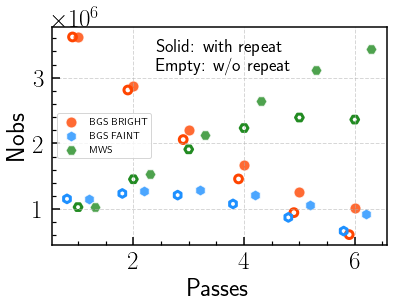

In [153]:
plt.scatter(
    [1, 2, 3, 4, 5, 6],
    [bgs_bright_pass1.sum(), (bgs_bright_pass2 - bgs_bright_pass1).sum(), (bgs_bright_pass3 - bgs_bright_pass2).sum(),
     (bgs_bright_pass4 - bgs_bright_pass3).sum(), (bgs_bright_pass5 - bgs_bright_pass4).sum(), (bgs_bright_pass6 - bgs_bright_pass5).sum()],
    marker='o', s=120, facecolor='orangered', edgecolor='w', label='BGS BRIGHT', alpha=0.8
)

plt.scatter(
    [1.2, 2.2, 3.2, 4.2, 5.2, 6.2],
    [bgs_faint_pass1.sum(), (bgs_faint_pass2 - bgs_faint_pass1).sum(), (bgs_faint_pass3 - bgs_faint_pass2).sum(),
     (bgs_faint_pass4 - bgs_faint_pass3).sum(), (bgs_faint_pass5 - bgs_faint_pass4).sum(), (bgs_faint_pass6 - bgs_faint_pass5).sum()],
    marker='h', s=120, facecolor='dodgerblue', edgecolor='w', label='BGS FAINT', alpha=0.8
)

plt.scatter(
    [1.3, 2.3, 3.3, 4.3, 5.3, 6.3],
    [mws_cat_pass1.sum(), (mws_cat_pass2 - mws_cat_pass1).sum(), (mws_cat_pass3 - mws_cat_pass2).sum(),
     (mws_cat_pass4 - mws_cat_pass3).sum(), (mws_cat_pass5 - mws_cat_pass4).sum(), (mws_cat_pass6 - mws_cat_pass5).sum()],
    marker='H', s=120, facecolor='forestgreen', edgecolor='w', label='MWS', alpha=0.8
)

plt.legend(loc='best')

plt.scatter(
    [0.9, 1.9, 2.9, 3.9, 4.9, 5.9],
    [bgs_bright_pass1.sum(), 
     ((bgs_bright_pass2 > 0).sum() - (bgs_bright_pass1 > 0).sum()), 
     ((bgs_bright_pass3 > 0).sum() - (bgs_bright_pass2 > 0).sum()), 
     ((bgs_bright_pass4 > 0).sum() - (bgs_bright_pass3 > 0).sum()), 
     ((bgs_bright_pass5 > 0).sum() - (bgs_bright_pass4 > 0).sum()), 
     ((bgs_bright_pass6 > 0).sum() - (bgs_bright_pass5 > 0).sum()), 
    ],
    marker='o', s=60, facecolor='none', edgecolor='orangered', linewidth=3
)

plt.scatter(
    [0.8, 1.8, 2.8, 3.8, 4.8, 5.8],
    [bgs_faint_pass1.sum(), 
     ((bgs_faint_pass2 > 0).sum() - (bgs_faint_pass1 > 0).sum()), 
     ((bgs_faint_pass3 > 0).sum() - (bgs_faint_pass2 > 0).sum()), 
     ((bgs_faint_pass4 > 0).sum() - (bgs_faint_pass3 > 0).sum()), 
     ((bgs_faint_pass5 > 0).sum() - (bgs_faint_pass4 > 0).sum()), 
     ((bgs_faint_pass6 > 0).sum() - (bgs_faint_pass5 > 0).sum()), 
    ],
    marker='h', s=60, facecolor='none', edgecolor='dodgerblue', linewidth=3
)

plt.scatter(
    [1, 2, 3, 4, 5, 6],
    [mws_cat_pass1.sum(), 
     ((mws_cat_pass2 > 0).sum() - (mws_cat_pass1 > 0).sum()), 
     ((mws_cat_pass3 > 0).sum() - (mws_cat_pass2 > 0).sum()), 
     ((mws_cat_pass4 > 0).sum() - (mws_cat_pass3 > 0).sum()), 
     ((mws_cat_pass5 > 0).sum() - (mws_cat_pass4 > 0).sum()), 
     ((mws_cat_pass6 > 0).sum() - (mws_cat_pass5 > 0).sum()), 
    ],
    marker='H', s=60, facecolor='none', edgecolor='forestgreen', linewidth=3
)

plt.xlabel("Passes", fontsize=25)
plt.ylabel("Nobs", fontsize=25)

plt.text(2.4, 3.4e6, "Solid: with repeat", fontsize=18)
plt.text(2.4, 3.1e6, "Empty: w/o repeat", fontsize=18)